# Sensitivity analysis

In this example we explore the sensitivity of PalmSim to the involved parameters.

Namely, we will run PalmSim multiple times with slightly different parameter choices and consider how this affects production.

For a more comprehensive and visual consideration of model uncertainty, see the example "model uncertainty".

## Potential Yield

### What we expect

Let us start of by considering the estimated potential yield.

Given the nature (see the figure below) of the model, it turns out the model is most sensitive to the following parameters:
    - k --- the parameter which sets light interception as a function of leaf area index
    - LUE --- the light use efficiency (g assimilate / MJ PAR)
    - respiration coefficients --- the cost of respiration
    
Note, this holds for all crop models that involve these parameters.

<img src="images/hoffman_diagram.png" alt="">

From the model design alone we can already reason and estimate the sensitivity to, for example, the light-use efficiency.

Namely, any increase (decrease) of the used light-use efficiency parameter proportionaly increases (decreases) the amount of assimilates that goes towards growth and maintenance.

However, the only way to quantify this sensitivity exactly is by testing the actual model.


### This Example   

This example has the following outline:

    1. We have a look at input **weather data** for a site in North Sumatra.
    2. We consider our best estimate of the potential bunch yield.
    3. We consider how this estimate changes if we change some key parameters.
 

## Weather data

This demo comes with weather data files which can be found in the inputs folder.

Here we consider weather data for North Sumatra.

In [1]:
# to allow us to work with spreadsheets import the "pandas" library
import pandas as pd

# to allow us to make plots, import a plotting library
import matplotlib.pyplot as plt

# read-in the csv-file
weather_data = pd.read_csv('./input/North Sumatra.csv',index_col='Date')
weather_data.index = pd.to_datetime(weather_data.index)

In [2]:
list(weather_data)

['solar (MJ/m2/day)', 'precip (mm/day)']

### Solar Radiation

C:\Users\zijls004\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


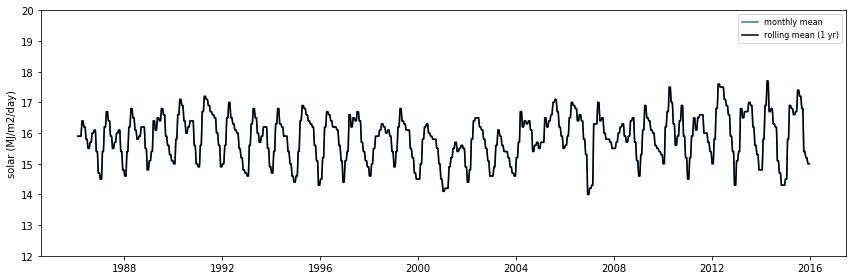

In [3]:
from plotting import tsplot

f,ax = tsplot(weather_data,'solar (MJ/m2/day)')
ax.set_ylim(12,20)
    
plt.tight_layout()

## Potential Yield --- Best Estimate

Now let us run PalmSim given this solar radiation to calculate the potential yield.

In [4]:
import sys
sys.path.append('../PalmSim')
sys.path.append('..')
from palmsim import PalmField

year_of_planting = weather_data.index.year[0]

# 1. Initialize the model
p = PalmField(year_of_planting=year_of_planting)

# 2. Couple the solar radiation data:
p.weather.radiation_series = weather_data['solar (MJ/m2/day)']

# 3. Run the model
df = p.run(duration=30*365)

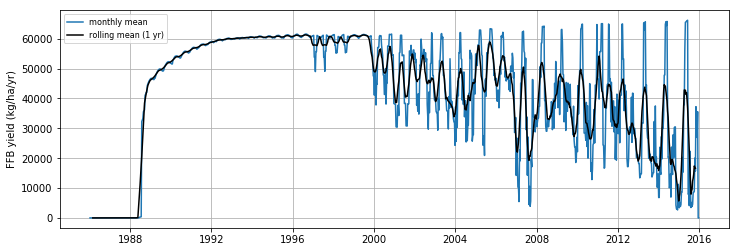

In [5]:
f,ax = tsplot(df, 'FFB_production (kg/ha/yr)')
ax.set_ylabel('FFB yield (kg/ha/yr)')
ax.grid()

Here we observe a plateau in production from 5 to 20 years after planting.

** Let us consider the mean production between 1992 and 2007. **

In [18]:
df.loc['1992':'2007','FFB_production (kg/ha/yr)'].mean()

52532.6625158485

# Sensitivity Analysis

Now let us consider how this production responds to different choices for the following parameters:
    - Light extinction (k)
    - Light-use efficiency (initial_light_efficiency)
    - Vegetative maintenance respiration (maintenance)
    
We can access these parameters directly from the model, for example light-use efficiency.

Note, each parameter comes with
    - information on the parameter
    - the source on which the value is based
    - uncertainty of the value
    - the unit

Changing the value can easily be done as is demonstrated.

In [19]:
# the parameters of the fronds --- for an overview of all parameters simply run "p.fronds.parameters"
p.fronds.parameters['initial_light_efficiency']

{'value': 10,
 'unit': 'ug_CO2/J',
 'info': 'Co-determines the light response (g CH2O/MJ) curve, the slope.',
 'source': 'Gerritsma, W., 1988. Light interception, leaf photosynthesis and sink-source relations in Oil Palm'}

In [20]:
# the default value
p.fronds.parameters['initial_light_efficiency']['value']

10

In [21]:
# changing the value
p.fronds.parameters['initial_light_efficiency']['value'] = 15

In [22]:
# the new value
p.fronds.parameters['initial_light_efficiency']

{'value': 15,
 'unit': 'ug_CO2/J',
 'info': 'Co-determines the light response (g CH2O/MJ) curve, the slope.',
 'source': 'Gerritsma, W., 1988. Light interception, leaf photosynthesis and sink-source relations in Oil Palm'}

# Basic sensitivity analysis

To do a basic sensitivity analysis let us run the model a few times with different values for the LUE and print the results.

To do so let us use 90%, 100% and 110% of the original value.

In [25]:
# 1. Set up the sensitivity analysis:
original_value = 10
factors = [0.95,1.0,1.05]

# 2. To store the results
res = {}

# 3. Running the analysis:
for factor in factors:

    # 1. Initialize the model
    p = PalmField(year_of_planting=year_of_planting)

    # 2. Couple the solar radiation data:
    p.weather.radiation_series = weather_data['solar (MJ/m2/day)']
    
    # 3. Set the parameter value
    initial_light_efficiency = factor * original_value
    p.fronds.parameters['initial_light_efficiency']['value'] = initial_light_efficiency
    
    df = p.run(duration=30*365)
    
    # 4. Mean production 5--20 YAP
    
    Y = df.loc['1992':'2007','FFB_production (kg/ha/yr)'].mean()
    
    # 5. Print result
    print('initial_light_efficiency = {:<3.3f} (ug_CO2/J), Mean Yield: {:3.3f} (kg/FB/year)'.format(initial_light_efficiency, Y))

initial_light_efficiency = 9.500 (ug_CO2/J), Mean Yield: 47468.422 (kg/FB/year)
initial_light_efficiency = 10.000 (ug_CO2/J), Mean Yield: 52532.663 (kg/FB/year)
initial_light_efficiency = 10.500 (ug_CO2/J), Mean Yield: 58101.380 (kg/FB/year)


Note the potential yield estimate is, as expected, very sensitive to the LUE estimate.

# More advanced sensitivity analysis

To do a more advanced sensitivity analysis let us
    - change the initial_light_efficiency, k and the maintenance coefficients by a factor: 1.05
    - store the results for each run
    - compare the results

This can be done in the following way.

Note this is a more advanced use of the model.

In [5]:
# to get all the model parameters let us get the following helper functions
from palmsim import get_parameters, set_parameters

In [6]:
parameters = get_parameters()

In [7]:
print(list(parameters))

['fronds', 'trunk', 'roots', 'assimilates', 'soil', 'weather', 'indeterminate', 'male', 'female', 'stalk', 'mesocarp_fibers', 'mesocarp_oil']


In [8]:
list(parameters['trunk'])

['density_a',
 'density_b',
 'specific_maintenance',
 'conversion_efficiency',
 'lignification_rate',
 'mass_loss_rate',
 'potential_growth_rates']

In [9]:
from copy import deepcopy

# A. Set up the sensitivity analysis:

# To do so let us make a small helper function
# which returns a "recipe" for a parameter variation

def make_job(sub_model=None, param=None, change=None, job_name=None):
    ''' Makes a job to process in the sensitivity analysis. '''
    
    if job_name is None:
        job_name = ' '.join([sub_model,param,str(change)]) 
    
    return {'job':job_name,
            'sub_model': sub_model, 
            'param': param,
            'change': change}
    
# Now we define all variations that we will test
jobs = [make_job(job_name = 'control'),
        make_job('fronds', 'initial_light_efficiency', 1),
        make_job('fronds', 'k', 1),
        
        make_job('fronds', 'initial_light_efficiency', 5),
        make_job('fronds', 'k', 5),

        make_job('fronds', 'initial_light_efficiency', -5),
        make_job('fronds', 'k', -5),
        
        make_job('fronds', 'initial_light_efficiency', 10),
        make_job('fronds', 'k', 10),
        
        make_job('fronds', 'specific_maintenance_leaflets', 1),
        make_job('fronds', 'specific_maintenance_rachis', 1),
        make_job('trunk', 'specific_maintenance', 1),
        make_job('roots', 'specific_maintenance', 1),
        
        make_job('fronds', 'specific_maintenance_leaflets', 5),
        make_job('fronds', 'specific_maintenance_rachis', 5),
        make_job('trunk', 'specific_maintenance', 5),
        make_job('roots', 'specific_maintenance', 5),
        ]

In [11]:
p.fronds.parameters

{'asymptotic_photosynthesis_rate': {'value': 720,
  'unit': 'ug_CO2/m2/s',
  'info': 'Co-determines the light response (g CH2O/m2/s) curve, the maximum value.',
  'source': 'Gerritsma, W., 1988.  Light interception, leaf photosynthesis and sink-source relations in Oil Palm'},
 'conversion_efficiency': {'value': 0.73,
  'unit': 'g_DM/g_CH2O',
  'info': 'The conversion efficiency of the fronds.',
  'source': 'Copied from Dufrene, E. and Ochs, R. and Saugier, B., 1990. Photosynthese et productivite du palmier a huile en liaison avec les facteurs climatiques. In turn based on van Kraalingen, D.W.G., 1989. See text below table II and table III.'},
 'fraction_leaflets': {'value': 0.25,
  'unit': '1',
  'info': 'Mass of the leaflets/frond mass not clear if frond mass includes/excludes petiole.',
  'source': 'Guestimated'},
 'fraction_rachis': {'value': 0.75,
  'unit': '1',
  'info': 'Mass of the rachis/frond mass not clear if frond mass includes/excludes petiole.',
  'source': 'Guestimated'},

In [10]:
# D. Run the parameter variations:
for job in jobs:
    
    print(job['job'])
    
    temp_parameters = deepcopy(parameters)

    k1 = job['sub_model']
    k2 = job['param']
    d = job['change']
    
    if not k1 is None:
        temp_parameters[k1][k2]['value'] *= (1+0.01*d)
        
    # 1. Initialize the model
    p = PalmField(year_of_planting=year_of_planting)

    set_parameters(p, temp_parameters)
    
    # 2. Couple the solar radiation data:
    p.weather.radiation_series = weather_data['solar (MJ/m2/day)']
    
    # 3. Run the simulation
    df = p.run(duration=30*365)
    
    Y = df.loc['1992':'2007','FFB_production (kg/ha/yr)'].mean()
        
    job['res'] = df

control
Setting settings...
fronds initial_light_efficiency 1
Setting settings...
fronds k 1
Setting settings...
fronds initial_light_efficiency 5
Setting settings...
fronds k 5
Setting settings...
fronds initial_light_efficiency -5
Setting settings...
fronds k -5
Setting settings...
fronds initial_light_efficiency 10
Setting settings...
fronds k 10
Setting settings...
fronds specific_maintenance_leaflets 1
Setting settings...
fronds specific_maintenance_rachis 1
Setting settings...
trunk specific_maintenance 1
Setting settings...
roots specific_maintenance 1
Setting settings...
fronds specific_maintenance_leaflets 5
Setting settings...
fronds specific_maintenance_rachis 5
Setting settings...
trunk specific_maintenance 5
Setting settings...
roots specific_maintenance 5
Setting settings...


Now let us analyze the results

In [11]:
# To do so let us construct a new table
table = {}

# We will focus on the yield
dfc = jobs[0]['res']
Yc = dfc.loc['1992':'2007','FFB_production (kg/ha/yr)'].mean()

for i, job in enumerate(jobs):
    
    df = job['res']
    
    Y = df.loc['1992':'2007','FFB_production (kg/ha/yr)'].mean()
    
    rel_change = job['change']
    
    rel_change_yield = 100*(Y-Yc)/Yc

    table[i] = {'Yield (kg FFB/ha/y)':Y,
                'Yield Change (%)':rel_change_yield,
                'Param. Change (%)':rel_change,
                'sub-model':job['sub_model'],
                'param':job['param']}

table = pd.DataFrame(table).T

table = table[['param', 'sub-model', 'Param. Change (%)', 'Yield (kg FFB/ha/y)', 'Yield Change (%)', ]]

# Result

In [12]:
table.sort_values(by='Yield Change (%)',ascending=False)

,param,sub-model,Param. Change (%),Yield (kg FFB/ha/y),Yield Change (%)
7,initial_light_efficiency,fronds,10,60656.7,15.4648
3,initial_light_efficiency,fronds,5,58101.4,10.6005
8,k,fronds,10,54001.1,2.79531
1,initial_light_efficiency,fronds,1,53758.4,2.33337
4,k,fronds,5,53379.9,1.61284
2,k,fronds,1,52920.7,0.738591
10,specific_maintenance_rachis,fronds,1,52693.3,0.305779
9,specific_maintenance_leaflets,fronds,1,52559,0.0502012
0,NaN,NaN,NaN,52532.7,0
12,specific_maintenance,roots,1,52527.9,-0.00909053
